In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=7cddb66b4ee6df67ae78bc19fcd8e6782762eb6137c184fd16d7aa60cebb8c8e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

In [ ]:
def printmg():
  GPUs = GPU.getGPUs()
  gpu = GPUs[0]
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printmg()

Gen RAM Free: 12.8 GB  | Proc size: 158.3 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import numpy as np
import os
import io
import time
import random
import shutil
from IPython.display import clear_output
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Activation, Dense, LeakyReLU, PReLU, ReLU, BatchNormalization,Embedding,Attention,LSTM,TimeDistributed, Bidirectional,Input 
from tensorflow.keras.layers import Lambda, Flatten, add, Conv1D, RNN, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K

In [ ]:
class Agent(object):
  
  def __init__(self, shapes):
    
    #vocab_size, embedding_dim, enc_units, batch_sz = shapes
    self.batch_sz = shapes[3]
    self.enc_units = shapes[2]
    self.vocab_size = shapes[0]
    self.embedding_dim = shapes[1]
  

  def estimator(self):
    inp = Input(shape = (1), name = 'input')
    dspace = Input(shape = (5), name = 'space')
    init = Input(shape = (1), name = 'init')
    space = Dense(128, activation = 'tanh')(dspace)
    f_h_state = Dense(128, activation = 'tanh')(init)
    f_c_state = Dense(128, activation = 'tanh')(init)
    b_h_state = Dense(128, activation = 'tanh')(init)
    b_c_state = Dense(128, activation = 'tanh')(init)
    f_state = Dense(128, activation = 'tanh')(init)
    b_state = Dense(128, activation = 'tanh')(init)
    model = Embedding(self.vocab_size, self.embedding_dim)(inp)
    model = Bidirectional(LSTM(self.enc_units,return_sequences = True, recurrent_initializer='glorot_uniform'))(model, initial_state=[f_h_state, f_c_state, b_h_state, b_c_state])
    model = Bidirectional(LSTM(self.enc_units, recurrent_initializer='glorot_uniform'))(model, initial_state=[f_state, space, b_state, space])
    model = Dense(128, activation = 'relu')(model)
    model = Dense(5, activation = 'relu')(model)
    val = Model(inputs = [inp, dspace, init], outputs = model)
    return val

In [ ]:
agent1 = Agent((200, 10, 128, 1)).estimator()
agent2 = Agent((200, 10, 128, 1)).estimator()

In [ ]:
agent2.summary()

In [ ]:
cell = np.ones((128,1))
#value = agent.predict({'input':data,'space':space,'init':cell})

In [ ]:
def compute_all_rewards(state, data):
  action = tf.one_hot([0,1,2,3,4],5,dtype = tf.float32)
  rewards = []
  for i in range(len(action)):
    prev_space = tf.math.divide_no_nan(tf.cast(tf.math.count_nonzero(state, axis = 1), dtype = tf.float32), 1.0)
    new_state = state + tf.math.multiply(tf.broadcast_to(action[i], [128,5] ), (tf.reshape(data[:,0],[128,1])))
    new_space = tf.math.divide_no_nan(tf.cast(tf.math.count_nonzero(new_state, axis = 1), dtype = tf.float32), 1.0)
    reward = new_space - prev_space
    rewards.append(tf.reshape(reward,[128,1]))
  rewards = tf.concat(rewards, axis = 1)
  return rewards

In [ ]:
def compute_all_Q(state, data, choice):
  rewards = compute_all_rewards(state, data)
  action = tf.expand_dims(tf.one_hot([0,1,2,3,4],5,dtype = tf.float32), 1)
  states = tf.math.multiply(action, tf.cast(tf.reshape(data[:,0],[128,1]),dtype = tf.float32)) + state
  qs = []
  for i in range(5):
    if choice == 1:
      p = agent1.predict({'input':data[:,1:],'space':states[i],'init':cell})
      index = tf.math.argmax(p, axis = -1)
      q = agent2.predict({'input':data[:,1:],'space':states[i],'init':cell})
      q = tf.math.multiply(q, tf.one_hot(index,5))
    else:
      p = agent2.predict({'input':data[:,1:],'space':states[i],'init':cell})
      index = tf.math.argmax(p, axis = -1)
      q = agent1.predict({'input':data[:,1:],'space':states[i],'init':cell})
      q = tf.math.multiply(q, tf.one_hot(index,5))
    q = tf.math.reduce_max(q, axis = 1)
    qs.append(tf.expand_dims(q,axis = -1))
  qs = tf.concat(qs, axis = -1)
  estimate = qs + rewards
  return estimate


In [ ]:
def normalize(input_data):
    return input_data.astype(np.float32)/1000.0
sz = [random.randrange(2,13,1) for i in range(500)]    
tr = []
for i in sz:
  sq = [random.sample(range(1,200),i) for j in range(128)]
  tr.append(tf.convert_to_tensor(normalize(np.array(sq))))

In [ ]:
def s_loss(action, truth):
  return K.abs(action-truth)

In [ ]:
adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
agent1.compile(loss = s_loss, optimizer = adam)
agent2.compile(loss = s_loss, optimizer = adam)

In [ ]:
agent1.load_weights('./agent1_18.h5')
agent2.load_weights('./agent1_18.h5')

In [ ]:
batch_num = len(tr)
epoch = 1000
batch_size = 128
capacity = np.array([[500,400,300,200,100] for i in range(128)])
capacity = normalize(capacity)
capacity = tf.convert_to_tensor(capacity,dtype = tf.float32)
cell = tf.convert_to_tensor(np.ones((128,1)),dtype = tf.float32)
l = []

In [ ]:
import shutil
import matplotlib.pyplot as plt
for e in range(4,epoch+1):
  losses = 0
  for num in tqdm(range(batch_num)):
    state = tf.convert_to_tensor(np.zeros((batch_size,5)),dtype = tf.float32)
    choice = np.random.choice([0,1])
    data = tr[num]
    loss = 0
    for i in range(len(data[1])):
      dynamic_state = capacity-state
      if i<len(data[1])-1:
        q_values = compute_all_Q(dynamic_state, data[:,i:], choice)
        total = q_values
      else:
        total = compute_all_rewards(dynamic_state, data[:,i:])
      #masking the reward to assign 0 probability to filled states
      expected_dynamic_state = tf.math.add(dynamic_state, -tf.reshape(data[:,i],[128,1]))
      cond = tf.math.less_equal(expected_dynamic_state,[0])
      inf = tf.convert_to_tensor(np.ones(state.shape)*-np.inf, dtype = tf.float32)
      total = total.numpy()
      if choice == 1:
        loss += agent2.train_on_batch({'input':data[:,i:],'space':dynamic_state,'init':cell}, total)
        action = agent2.predict({'input':data[:,i:],'space':dynamic_state,'init':cell})
      else:
        loss += agent1.train_on_batch({'input':data[:,i:],'space':dynamic_state,'init':cell}, total)
        action = agent1.predict({'input':data[:,i:],'space':dynamic_state,'init':cell})
      action_probs = tf.math.divide_no_nan(1.0,action)
      action_probs = tf.where(cond, inf, action_probs)
      action_probs = tf.nn.softmax(action_probs)
      action = tf.random.categorical(action,1)
      action = tf.one_hot(tf.squeeze(action, axis = -1),5,dtype = tf.float32)
      state = (tf.math.divide_no_nan(tf.math.multiply(action, tf.cast(tf.reshape(data[:,i],[128,1]),dtype = tf.float32)), 1.0 ) + state)
    losses += loss/len(data[1])
  l.append(losses/batch_num)
  clear_output()
  print(e, losses/batch_num)
  plt.plot(l)
  plt.show()
  path1 = 'agent1'+str(e)+'.h5'
  path2 = 'agent2'+str(e)+'.h5'
  agent1.save(path1)
  agent2.save(path2)
  #shutil.copy("./"+path1,"/content/drive/My Drive/NCO/"+path1)
  #shutil.copy("./"+path2,"/content/drive/My Drive/NCO/"+path2)

  
  

In [ ]:
agent1.save_weights('./abc.h5')

In [ ]:
g_items

[('bidirectional', <Closed HDF5 group>),
 ('bidirectional_1', <Closed HDF5 group>),
 ('dense', <Closed HDF5 group>),
 ('dense_1', <Closed HDF5 group>),
 ('dense_2', <Closed HDF5 group>),
 ('dense_3', <Closed HDF5 group>),
 ('dense_4', <Closed HDF5 group>),
 ('dense_5', <Closed HDF5 group>),
 ('dense_6', <Closed HDF5 group>),
 ('dense_7', <Closed HDF5 group>),
 ('dense_8', <Closed HDF5 group>),
 ('embedding', <Closed HDF5 group>),
 ('init', <Closed HDF5 group>),
 ('input', <Closed HDF5 group>),
 ('space', <Closed HDF5 group>)]

In [ ]:
total = tf.ones((128,5), dtype = tf.float32)

In [ ]:
import h5py
with h5py.File('./agent125.h5','r') as hdf:
  g_items = list(hdf.items())
  g = hdf.get('model_weights')
  g_items = list(g.items())
  g1 = g.get('dense')
  g_items = list(g1.items())
  g11 = g1.get('dense')
  '''g_items = list(g11.items())
  g111 = g11.get('backward_lstm')
  g_items = list(g111.items())
  g1111 = g111.get('lstm_cell_2')
  g_items = list(g1111.items())'''
  g11111 = np.array(g11.get('kernel:0'))
  
    

In [ ]:
g11111

In [ ]:
agent1.train_on_batch({'input':data[:,i:],'space':dynamic_state,'init':cell}, total)

0.9357037544250488

In [ ]:
agent2.train_on_batch({'input':data[:,i:],'space':dynamic_state,'init':cell}, total)

0.978537917137146

In [ ]:
state = tf.convert_to_tensor(np.zeros((batch_size,5)),dtype = tf.float32)
for i in range(len(data[1])):
  dynamic_state = capacity-state
  expected_dynamic_state = tf.math.add(dynamic_state, -tf.reshape(data[:,i],[128,1]))
  cond = tf.math.less_equal(expected_dynamic_state,[0])
  inf = tf.convert_to_tensor(np.ones(state.shape)*-np.inf, dtype = tf.float32)
  action = agent1.predict({'input':data[:,i:],'space':dynamic_state,'init':cell})
  action_probs = tf.math.divide_no_nan(1.0,action)
  action_probs = tf.where(cond, inf, action_probs)
  action_probs = tf.nn.softmax(action_probs)
  action = tf.math.argmax(action_probs,axis = 1)
  action = tf.cast(tf.expand_dims(action, axis = -1), dtype = tf.int64)
  action = tf.one_hot(tf.squeeze(action, axis = -1),5,dtype = tf.float32)
  state = tf.math.multiply(action, tf.cast(tf.reshape(data[:,i],[128,1]),dtype = tf.float32))  + state

In [ ]:
state

<tf.Tensor: shape=(128, 5), dtype=float32, numpy=
array([[0.499     , 0.359     , 0.288     , 0.        , 0.        ],
       [0.484     , 0.377     , 0.189     , 0.143     , 0.        ],
       [0.47400004, 0.359     , 0.17      , 0.        , 0.        ],
       [0.48899996, 0.376     , 0.239     , 0.173     , 0.        ],
       [0.49999997, 0.333     , 0.        , 0.        , 0.        ],
       [0.492     , 0.36699998, 0.254     , 0.        , 0.        ],
       [0.483     , 0.37199998, 0.198     , 0.        , 0.        ],
       [0.49000004, 0.335     , 0.137     , 0.        , 0.        ],
       [0.473     , 0.282     , 0.284     , 0.169     , 0.        ],
       [0.495     , 0.37199998, 0.        , 0.        , 0.        ],
       [0.47500002, 0.352     , 0.176     , 0.131     , 0.        ],
       [0.471     , 0.368     , 0.282     , 0.129     , 0.        ],
       [0.486     , 0.321     , 0.        , 0.        , 0.        ],
       [0.5       , 0.376     , 0.        , 0.       

In [ ]:
  action = agent1.predict({'input':data[:,i:],'space':dynamic_state,'init':cell})
  action_probs = tf.math.divide_no_nan(1.0,action)
  action_probs = tf.where(cond, inf, action_probs)
  action_probs = tf.nn.softmax(action_probs)
  action = tf.math.argmax(action_probs,axis = 1)
  action = tf.cast(tf.expand_dims(action, axis = -1), dtype = tf.int64)
  action = tf.one_hot(tf.squeeze(action, axis = -1),5,dtype = tf.float32)

In [ ]:
agent1.predict({'input':data[:,i:],'space':dynamic_state,'init':cell})

array([[0.04067285, 0.12970401, 0.1252716 , 0.06536461, 0.        ],
       [0.04085384, 0.12970202, 0.12526758, 0.06528489, 0.        ],
       [0.04115961, 0.12967679, 0.12531948, 0.06512823, 0.        ],
       [0.04164393, 0.1295908 , 0.12551595, 0.06483687, 0.        ],
       [0.04142017, 0.12963139, 0.12542559, 0.06497148, 0.        ],
       [0.04089319, 0.12970152, 0.12526672, 0.06526756, 0.        ],
       [0.04075944, 0.12970309, 0.12526976, 0.06532648, 0.        ],
       [0.04128085, 0.12965588, 0.12536904, 0.0650553 , 0.        ],
       [0.04068073, 0.1297039 , 0.12527142, 0.06536117, 0.        ],
       [0.04129905, 0.12965271, 0.12537639, 0.06504438, 0.        ],
       [0.04121417, 0.12966742, 0.12534179, 0.06509544, 0.        ],
       [0.04151701, 0.12961401, 0.12546481, 0.06491321, 0.        ],
       [0.04155933, 0.12960628, 0.12548189, 0.06488775, 0.        ],
       [0.04165602, 0.12958859, 0.12552075, 0.0648296 , 0.        ],
       [0.04118386, 0.12967262, 0.

In [ ]:
compute_all_Q(dynamic_state, data[:,i:],1)

<tf.Tensor: shape=(128, 5), dtype=float32, numpy=
array([[0.04220916, 0.04204288, 0.04222726, 0.04206713, 0.04210026],
       [0.0429012 , 0.04106094, 0.01315821, 0.04121596, 0.01372691],
       [0.04311195, 0.0410597 , 0.01301243, 0.0412158 , 0.01336014],
       [0.0433759 , 0.04133027, 0.01284268, 0.04140888, 0.01279383],
       [0.04268888, 0.04252356, 0.04270095, 0.04255452, 0.04257765],
       [0.0423428 , 0.04215699, 0.04234669, 0.04219003, 0.04222551],
       [0.04238224, 0.0418747 , 0.04242775, 0.04194995, 0.04205385],
       [0.04311497, 0.04129664, 0.01326962, 0.04146313, 0.01340708],
       [0.04222872, 0.04202442, 0.0422514 , 0.04205592, 0.04209507],
       [0.04259233, 0.04246835, 0.04259499, 0.04249045, 0.04251452],
       [0.04297926, 0.04147601, 0.01355483, 0.04163977, 0.01370644],
       [0.0433041 , 0.04126664, 0.01294624, 0.04136952, 0.01294685],
       [0.04280445, 0.04255654, 0.0428265 , 0.04260618, 0.04262991],
       [0.0433041 , 0.04154865, 0.01313521, 0.0416628

In [ ]:
action

array([[0.04067285, 0.12970401, 0.1252716 , 0.06536461, 0.        ],
       [0.04085384, 0.12970202, 0.12526758, 0.06528489, 0.        ],
       [0.04115961, 0.12967679, 0.12531948, 0.06512823, 0.        ],
       [0.04164393, 0.1295908 , 0.12551595, 0.06483687, 0.        ],
       [0.04142017, 0.12963139, 0.12542559, 0.06497148, 0.        ],
       [0.04089319, 0.12970152, 0.12526672, 0.06526756, 0.        ],
       [0.04075944, 0.12970309, 0.12526976, 0.06532648, 0.        ],
       [0.04128085, 0.12965588, 0.12536904, 0.0650553 , 0.        ],
       [0.04068073, 0.1297039 , 0.12527142, 0.06536117, 0.        ],
       [0.04129905, 0.12965271, 0.12537639, 0.06504438, 0.        ],
       [0.04121417, 0.12966742, 0.12534179, 0.06509544, 0.        ],
       [0.04151701, 0.12961401, 0.12546481, 0.06491321, 0.        ],
       [0.04155933, 0.12960628, 0.12548189, 0.06488775, 0.        ],
       [0.04165602, 0.12958859, 0.12552075, 0.0648296 , 0.        ],
       [0.04118386, 0.12967262, 0.

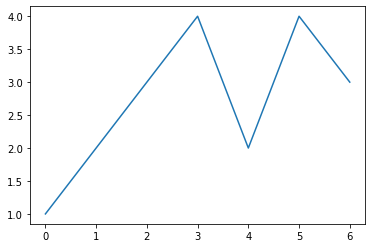

In [ ]:
compute_all_Q(state,data,choice)

<tf.Tensor: shape=(128, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1.

In [ ]:
a

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>

In [ ]:
states = tf.math.multiply(action, tf.ones((10,1), dtype = tf.float32)) + state

In [ ]:
tf.reshape(states, [5,10,5])

In [ ]:
data = [random.sample(range(1,50),15) for i in range(10)]
data = np.array(data)
def normalize(input_data):
    return input_data.astype(np.float32)/1000.0
data = normalize(data)

In [ ]:
k = agent2.predict({'input':data,'space':dynamic_state,'init':cell})

In [ ]:
qs = []
for i in range(5):
  q = agent.predict({'input':data,'space':states[i],'init':cell})
  q = tf.math.reduce_max(q, axis = 1)
  qs.append(tf.expand_dims(q,axis = -1))
qs = tf.concat(qs, axis = -1)

In [ ]:
data[0]

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([0.03 , 0.179, 0.112, 0.174, 0.18 , 0.148, 0.136, 0.188, 0.108,
       0.197, 0.029], dtype=float32)>

In [ ]:
loss = agent2.train_on_batch({'input':data,'space':dynamic_state,'init':cell}, total)

In [ ]:
tf.math.reduce_max(tf.expand_dims(states, axis = -2), axis = 3)

<tf.Tensor: shape=(5, 10, 1), dtype=float32, numpy=
array([[[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]],

       [[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]]], dtype=float32)>

In [ ]:
tf.math.reduce_max(q, axis = 1)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.01292582, 0.01292582, 0.01292582, 0.01292582, 0.01292582,
       0.01292582, 0.01292582, 0.01292582, 0.01292582, 0.01292582],
      dtype=float32)>